In [1]:
import os
import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
#Change this to the location of the NSynth dataset on your machine
files = os.listdir('/media/data/nsynth-train/audio')

In [79]:
'''
Loads a an audio file from the NSynth dataset
and converts it into an STFT
'''
def loadBatch(filenum):
    #The size is 201 x 201 due to using n_fft=400 for the STFT
    batch = torch.zeros(1, 201, 201, 2)

    file, sampRate = torchaudio.load('/media/data/nsynth-train/audio/'+files[filenum])
    #Take the short time fourier transform of the first 20k samples
    stft = torch.stft(file[0, 0:20000], n_fft=400)
    batch[0] = stft
    #Print the name of the file
    print(files[filenum])
    
    return batch

In [274]:
class Network(nn.Module):
    def __init__(self, size, hid):
        super().__init__()
        
        #Three layers, the first and last of which
        #are the input size.
        #hid is the size of the hidden layer
        self.inpt = nn.Linear(size, hid)
        self.hidden = nn.Linear(hid, hid)
        self.out = nn.Linear(hid, size)
        
    def forward(self, x):
        h1 = torch.relu( self.inpt(x) )
        h2 = torch.relu( self.hidden(h1) )
        output = self.out( h2 )
        
        return output

In [299]:
#initilize network with a hidden size of 2048
net = Network(201, 2048).cuda()
opt = optim.Adam(net.parameters(), lr=0.000001)

loss_function = nn.L1Loss()

In [300]:
stft = loadBatch(0)

organ_electronic_021-091-075.wav


In [302]:
stft = stft.cuda()
for epoch in range(1000):
    loss = 0
    #We perform a training pass for each slice of the STFT
    for b in range(0, 200):

        inpt = stft[:, :, b, 0]
        
        #Add random noise for regularization
        inpt += (torch.randn(inpt.shape)*0.01).cuda()
        predict = net(inpt.cuda())
        
        #Loss is calculated from the next slice of the STFT
        loss = loss_function(predict, stft[:, :, b+1, 0])
        loss.backward()
        opt.step()


organ_electronic_047-070-100.wav


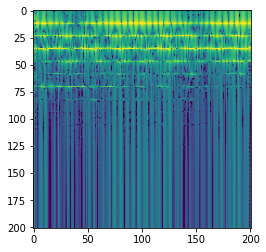

In [297]:
#Prints a spectrogram of the input data
sgram = np.log( np.abs( stft.numpy()[:, :, 0]) )
plt.imshow(sgram, vmin=-5, vmax = 3)

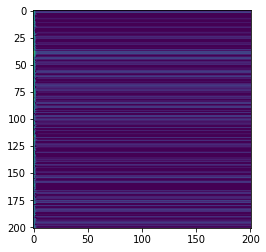

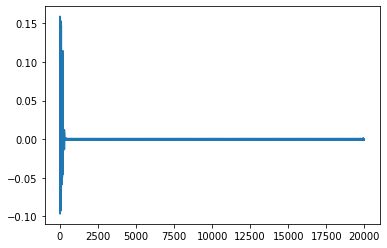

In [303]:
#Seeded with the first slice of the training data,
#generate the output
with torch.no_grad():
    #Network and input data should be moved from CPU to GPU
    net = net.cpu()
    stft = stft.cpu()
    
    #The third dimension accounts for both real and imaginary (phase)
    #components of the STFT, but we will only be using the real
    output = torch.zeros(201, 201, 2)

    output[:, 0, 0] = stft[0, :, 0, 0]
    
    #For each vertical slice, feed in the previous output
    for step in range(1, 201):
        netout = net(output[:, step-1, 0].view(1, 201))
        output[:, step, 0] = netout
        
    plt.imshow(np.log(np.abs(output[:, :, 0])), vmin=-5, vmax=3)
    plt.show()
    
    #Audio is generated from taking the inverse STFT
    sound = torchaudio.functional.istft(output, n_fft=400)
    plt.plot(sound)

In [269]:
#Output an audio file from what the network generated
import wave
oput = sound.detach().numpy()
w = wave.open('output.wav', 'wb')
w.setparams((1, 2, 16000, oput.shape[0], 'NONE', 'NONE'))
w.writeframes((oput * 60000).astype('int16'))